# Simple Classifiers and preprocessing of the data

In [1]:
import sys
sys.path.append('..')

import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from src.plot_utils import hist, count, scatter
from dotenv import load_dotenv

SEED = 42

## Importing of the data and spliting

next, we will import the dataset:

In [2]:
CSV_PATH = '../data/chartex_clean.csv'

df = pd.read_csv(CSV_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4443 entries, 0 to 4442
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   track_name                    4442 non-null   object 
 1   track_pop                     4443 non-null   int64  
 2   artist                        4442 non-null   object 
 3   artist_pop                    4443 non-null   int64  
 4   album                         4442 non-null   object 
 5   danceability                  4443 non-null   float64
 6   energy                        4443 non-null   float64
 7   key                           4443 non-null   float64
 8   loudness                      4443 non-null   float64
 9   mode                          4443 non-null   float64
 10  speechiness                   4443 non-null   float64
 11  acousticness                  4443 non-null   float64
 12  instrumentalness              4443 non-null   float64
 13  liv

Let's fill all missing data with the expectation:

In [3]:
df = df.drop(['track_name', 'artist', 'album', 'id', 'song_name', 'artist_name'], axis = 1)
means = df.mean()
df.fillna(value=means, inplace=True)

next, we will split the target feature (track_pop) from the rest of the features and split to train and test sets. In addition, we will replace track_pop with a new binary feature that indicate if a track is popular according to track_pop and threshold of our choice and it will be out target feature for **classification**:

In [4]:
from sklearn.model_selection import train_test_split

df = df.drop(['artist_pop', 'number_of_videos', 'number_of_videos_last_14days', 'total_likes_count', 'key',], axis = 1)
columns = df.columns

X, y = df.drop(['track_pop'], axis=1).values,  df['track_pop'].values

#for classification:
# 50 is the threshold.
y = (y > 50).astype('int32')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, test_size=0.25)

In [5]:
for i, column in enumerate(columns):
    if i == 0:
        print(f'Target: {column}')
    else:
        print(f'#{i-1} : {column}')

Target: track_pop
#0 : danceability
#1 : energy
#2 : loudness
#3 : mode
#4 : speechiness
#5 : acousticness
#6 : instrumentalness
#7 : liveness
#8 : valence
#9 : tempo
#10 : duration_ms
#11 : time_signature


Let's investigate a bit the train and test sets:

In [6]:
print("Train:")
print("#samples in train:", y_train.shape[0])
print("#popular samples in train:", y_train.sum().item()/y_train.shape[0])

print("\nTest:")
print("#samples in test:", y_test.shape[0])
print("#popular samples in test:", y_test.sum().item()/y_test.shape[0])

Train:
#samples in train: 3332
#popular samples in train: 0.4339735894357743

Test:
#samples in test: 1111
#popular samples in test: 0.44014401440144013


## Simple classifiers:

In [7]:
from sklearn.model_selection import cross_validate

def print_accuracy(model, X_train, X_test, y_train, y_test):
    y_pred = model.predict(X_train)
    print("train accuracy =",(y_train == y_pred).mean())

    y_pred = model.predict(X_test)
    print("test accuracy =",(y_test == y_pred).mean())

splitted_data = (X_train, X_test, y_train, y_test)

### Logistic regression:

Now we are ready to train the models.

We will start with Logistic regression with l2 regularization:

In [8]:
from sklearn import linear_model

logit_lin_l2_model = linear_model.LogisticRegression(C = 5)
logit_lin_l2_model.fit(X_train,y_train)

LogisticRegression(C=5)

In [9]:
print_accuracy(logit_lin_l2_model, *splitted_data)

train accuracy = 0.5660264105642256
test accuracy = 0.5598559855985599


We can see that the model is just better than random classifier.

Considering that we used the model on the raw data it is not suprising that the model did bad job in predicting the popularity.

Let's try decision trees!

### Decision Trees:

Let's put regularization by forcing all leaves in the tree to have at least 10 samples from the training set:

In [10]:
from sklearn import tree

tree_model = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 10)

tree_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_split=10)

In [11]:
print_accuracy(tree_model, *splitted_data)

train accuracy = 0.924969987995198
test accuracy = 0.5841584158415841


Has we can see from the result, the model suffers from overfitting. So, let's do cross validation on min_samples_split:

In [12]:
from sklearn import tree

list_of_mins = [10,50,100,300,500,1000]
accuracy_per_value = []

for min_leaf in list_of_mins:
    tree_model = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_split = min_leaf)
    cv_result = cross_validate(tree_model, X_train, y_train, cv=3, scoring= ('accuracy'))
    accuracy_per_value.append(cv_result['test_score'].mean())

optim_min = list_of_mins[np.argmax(accuracy_per_value)]
tree_model = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_split = optim_min)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_split=300)

And then, the accuracies of the model with the optimal min_samples_split is:

In [13]:
print_accuracy(tree_model, *splitted_data)

train accuracy = 0.6407563025210085
test accuracy = 0.5607560756075608


Still not a good result. We need to remember that we are still working on the row data and didn't do any feature mapping

### AdaBoost classifier:

Let's play with AdaBoost a bit:

In [14]:
from sklearn.ensemble import AdaBoostClassifier

#the base model is stump - decision tree with maximal depth of 1.
adaboost_model = AdaBoostClassifier(n_estimators=50, learning_rate=20)
adaboost_model.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=20)

In [15]:
print_accuracy(adaboost_model, *splitted_data)

train accuracy = 0.5669267707082833
test accuracy = 0.558055805580558


Let's see if Cross validation can help it:

In [16]:
estimators = [10, 25, 50]
lr = [0.01, 0.1, 1]
accuracy_per_value = []

for n_estimator in estimators:
    for rate in lr:
        adaboost_model = AdaBoostClassifier(n_estimators=n_estimator, learning_rate= rate)
        cv_result = cross_validate(adaboost_model, X_train, y_train, cv=3, scoring= ('accuracy'))
        accuracy_per_value.append(cv_result['test_score'].mean())

optim_idx = np.argmax(accuracy_per_value)
adaboost_model = AdaBoostClassifier(n_estimators= estimators[optim_idx//len(lr)], learning_rate= lr[optim_idx%len(lr)])
adaboost_model.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.01, n_estimators=10)

In [17]:
print_accuracy(adaboost_model, *splitted_data)

train accuracy = 0.5660264105642256
test accuracy = 0.5598559855985599


### MLP model:

Let's check how many features we have:

In [8]:
input_dim = X_train.shape[1]
output_dim = 2
train_samples = X_train.shape[0]

print("input dim:", input_dim)
print("number of train samples:", train_samples)
print("number of test samples:", X_test.shape[0])

input dim: 12
number of train samples: 3332
number of test samples: 1111


In [9]:
import torch
import torch.nn as nn

torch.manual_seed(SEED)

X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.long)

X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.long)


In [10]:
batch_size = 64

num_epochs = 100
num_batches = train_samples//batch_size

#### Simple MLP:

We will start by checking if it is possible to overfit the MLP on small subset of the training set: (in order to see if the implementation of trainer and dataIterator module are good):

In [11]:
from project.trainer import trainer

mlp_overfit = nn.Sequential(
    nn.BatchNorm1d(input_dim),
    nn.Linear(input_dim, 16),
    nn.LeakyReLU(),
    nn.Linear(16, output_dim),
    nn.Softmax(dim=1)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_overfit.parameters(), lr=1e-2)

In [13]:
mlp_trainer = trainer(mlp_overfit,optimizer,loss_fn,num_epochs,50,True)

loss_list, accuracy_list = mlp_trainer.fit(X_train[:50],y_train[:50])

100%|██████████| 100/100 [00:00<00:00, 1060.68it/s]

Epoch #99: Loss=0.3544886112213135, accuracy=0.96


In [14]:
mlp_trainer.evaluate(X_test,y_test)

(0.7538391351699829, 0.5427542924880981)

We got overfitting! As a result, we can continue:

In [15]:
mlp_model = nn.Sequential(
    nn.BatchNorm1d(input_dim),
    nn.Linear(input_dim, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 32),
    nn.LeakyReLU(),
    nn.Linear(32, output_dim),
    nn.Softmax(dim=1)
)

print(mlp_model)

Sequential(
  (0): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=12, out_features=64, bias=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Linear(in_features=32, out_features=2, bias=True)
  (6): Softmax(dim=1)
)


In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,start_factor=1.0,end_factor=1e-4,total_iters=5)

In [17]:
from project.trainer import trainer

mlp_trainer = trainer(mlp_model,optimizer,loss_fn,num_epochs,batch_size,True)

loss_list, accuracy_list = mlp_trainer.fit(X_train,y_train)

100%|██████████| 100/100 [00:06<00:00, 16.21it/s]

Epoch #99: Loss=30.82217139005661, accuracy=0.7226890756302521


Text(0, 0.5, 'accuracy')

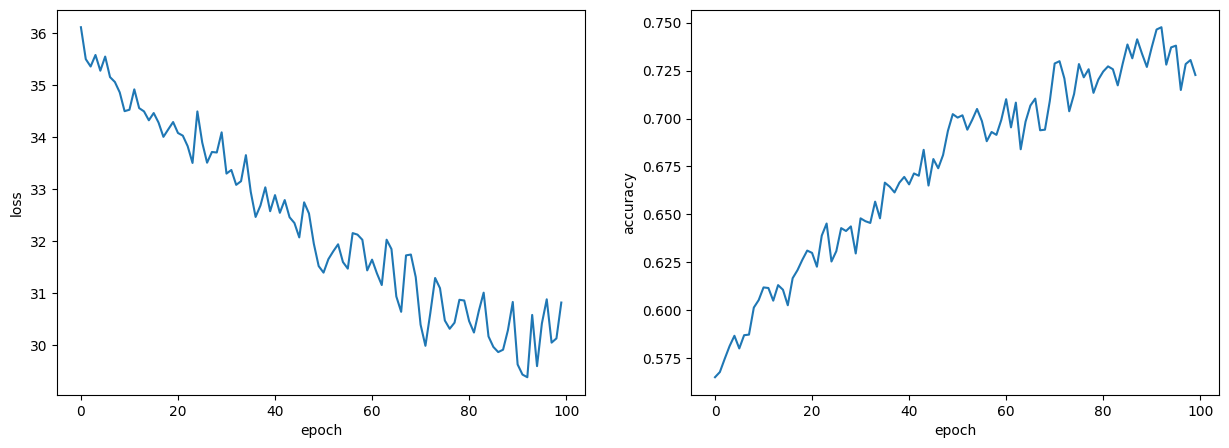

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(15,5))

axs[0].plot(range(num_epochs), loss_list)
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')

axs[1].plot(range(num_epochs), accuracy_list)
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')


In [19]:
y_pred = mlp_model(X_test)
test_accuracy = (torch.argmax(y_pred,dim=1) == y_test).sum().item() / X_test.shape[0]
print(f'Test accuracy: {test_accuracy}')

Test accuracy: 0.5688568856885688


We can notice a bit of overfitting because while the train accuracy is above above 74%, the test accuracy is just above 60%.

In addition, it seems that the learning rate is not correct because the decrease in the loss is very small, preventing the model to learn well.

We will next do cross validation on few hyperparameters in order to get the better model.

#### Cross validation for MLP:

In [11]:
import torch
import torch.nn as nn
from project.cross_val import setConfigure, crossValidate

In [13]:
from sklearn.model_selection import KFold
from project.trainer import trainer

num_epochs = 100

kf = KFold(2,shuffle=True, random_state=SEED)

configures = setConfigure({'lr':[1e-3,1e-4]})

results = []
for config in configures:
    mlp_model = nn.Sequential(
        nn.BatchNorm1d(input_dim),
        nn.Linear(input_dim, 64),
        nn.LeakyReLU(),
        nn.Linear(64, 32),
        nn.LeakyReLU(),
        nn.Linear(32, output_dim),
        nn.Softmax(dim=1)
    )
    print(f'The configuration is {config}:')
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(mlp_model.parameters(), config['lr'])
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, total_iters=10)

    mlp_trainer = trainer(mlp_model,optimizer,loss_fn,num_epochs,batch_size,True)
    results.append(crossValidate(mlp_trainer, X_train, y_train, kf))

The configuration is {'lr': 0.001}:


100%|██████████| 100/100 [00:03<00:00, 30.03it/s]


Epoch #99: Loss=15.570819646120071, accuracy=0.7310924369747899


100%|██████████| 100/100 [00:03<00:00, 29.40it/s]


Epoch #99: Loss=15.952063202857971, accuracy=0.734093637454982
The configuration is {'lr': 0.0001}:


100%|██████████| 100/100 [00:03<00:00, 29.21it/s]


Epoch #99: Loss=17.733993113040924, accuracy=0.5978391356542617


100%|██████████| 100/100 [00:03<00:00, 28.57it/s]

Epoch #99: Loss=17.48850554227829, accuracy=0.6182472989195679


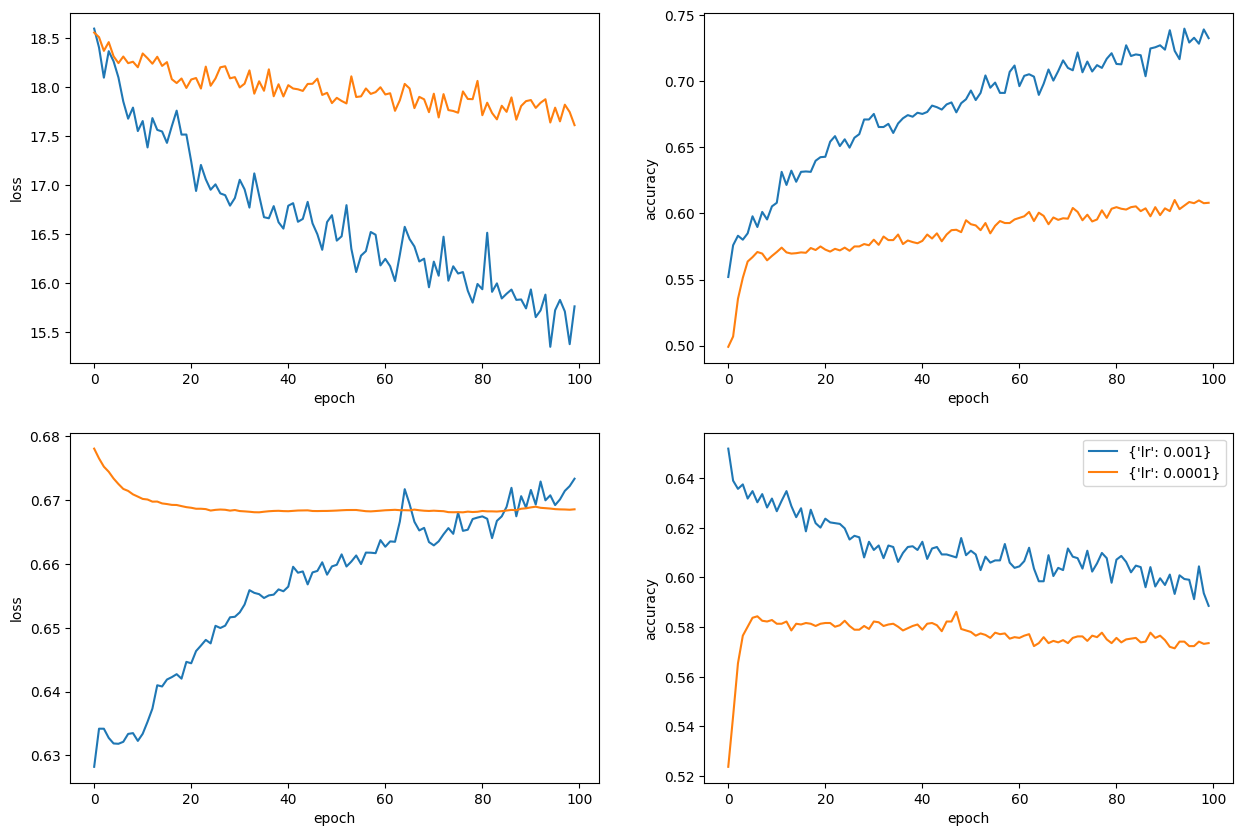

In [14]:
from project.utills import plotCV

plotCV(results, configures)

### Others:

In [ ]:
#Save the entire model:
#torch.save(model, "my_model.pickle")
#model = torch.load("my_model.pickle")

#Save only the weights: (recommended)
#torch.save(model.state_dict(), "my_model.pickle")
#model = nn.Sequential(...)
#model.load_state_dict(torch.load("my_model.pickle"))